In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

In [11]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../../data/initial_data/awards_players.csv")
coaches = pd.read_csv("../../data/initial_data/coaches.csv")
players_teams = pd.read_csv("../../data/initial_data/players_teams.csv")
players = pd.read_csv("../../data/initial_data/players.csv")
series_post = pd.read_csv("../../data/initial_data/series_post.csv")
teams_post = pd.read_csv("../../data/initial_data/teams_post.csv")
teams = pd.read_csv("../../data/initial_data/teams.csv")

## Player Based Development Curve

In [12]:
# ================================
# PLAYER GAME SCORE
# ================================
def get_player_game_score(players_teams_df, player_id, year):
    """
    Compute a player's game score for a given year.
    Returns a clean Python dictionary.
    """
    df_player = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ].copy()

    if df_player.empty:
        return {
            "playerID": player_id,
            "year": year,
            "tmID": None,
            "Game_Score_Total": None,
            "Game_Score_Per_Game": None,
            "Game_Score_Per_Minute": None
        }

    # Base game score formula
    base_score = (
        df_player["points"]
        + 0.4 * df_player["fgMade"]
        - 0.7 * df_player["fgAttempted"]
        - 0.4 * (df_player["ftAttempted"] - df_player["ftMade"])
        + 0.7 * df_player["oRebounds"]
        + 0.3 * df_player["dRebounds"]
        + df_player["steals"]
        + 0.7 * df_player["assists"]
        + 0.7 * df_player["blocks"]
        - 0.4 * df_player["PF"]
        - df_player["turnovers"]
    )

    df_player["Game_Score_Total"] = base_score
    df_player["Game_Score_Per_Game"] = base_score / df_player["GP"].replace(0, np.nan)
    df_player["Game_Score_Per_Minute"] = base_score / df_player["minutes"].replace(0, np.nan)

    return {
        "playerID": player_id,
        "year": int(year),
        "tmID": ",".join(df_player["tmID"].unique()),
        "Game_Score_Total": float(df_player["Game_Score_Total"].sum(skipna=True)),
        "Game_Score_Per_Game": float(df_player["Game_Score_Per_Game"].mean(skipna=True)),
        "Game_Score_Per_Minute": float(df_player["Game_Score_Per_Minute"].mean(skipna=True)),
    }

example = get_player_game_score(players_teams, "aycocan01w", 1)
print("Example Player Game Score:\n", example)

Example Player Game Score:
 {'playerID': 'aycocan01w', 'year': 1, 'tmID': 'MIN,SEA', 'Game_Score_Total': 1.4000000000000001, 'Game_Score_Per_Game': -0.3999999999999999, 'Game_Score_Per_Minute': 0.13928571428571426}


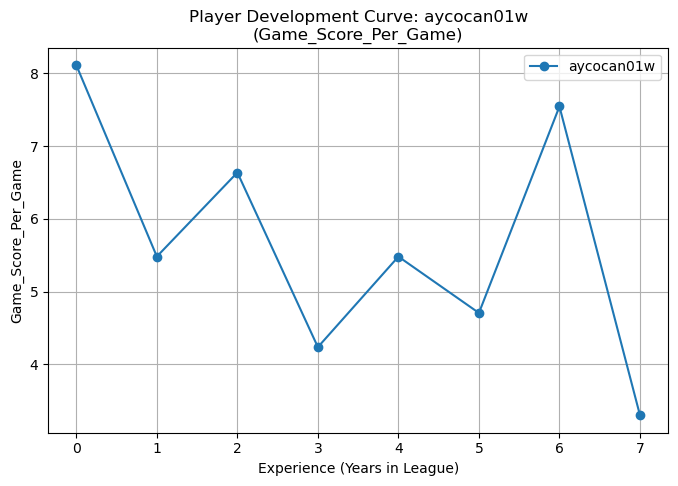

In [13]:
# ============================================================
# 1. PLAYER CAREER DEVELOPMENT CURVE
# ============================================================

def get_player_career_curve(players_teams_df, player_id):
    """
    Computes game score for every season of a player's career
    and returns a DataFrame with experience-year indexing.
    """
    df = players_teams_df[players_teams_df["playerID"] == player_id]
    
    if df.empty:
        return pd.DataFrame()

    seasons = sorted(df["year"].unique())
    first_year = seasons[0]

    rows = []
    for yr in seasons:
        score_data = get_player_game_score(players_teams_df, player_id, yr)
        rows.append(score_data)

    career_df = pd.DataFrame(rows)

    # Add experience (0 = rookie season)
    career_df["Experience"] = career_df["year"] - first_year

    # Keep sorted
    career_df = career_df.sort_values("Experience")

    return career_df


def plot_player_career_curve(career_df, player_id, metric="Game_Score_Per_Game"):
    """
    Plot a player's development curve.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(
        career_df["Experience"],
        career_df[metric],
        marker="o",
        label=f"{player_id}"
    )

    plt.title(f"Player Development Curve: {player_id}\n({metric})")
    plt.xlabel("Experience (Years in League)")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
career = get_player_career_curve(players_teams, "abrossv01w")
plot_player_career_curve(career, "aycocan01w")

## League Wide Development Curve

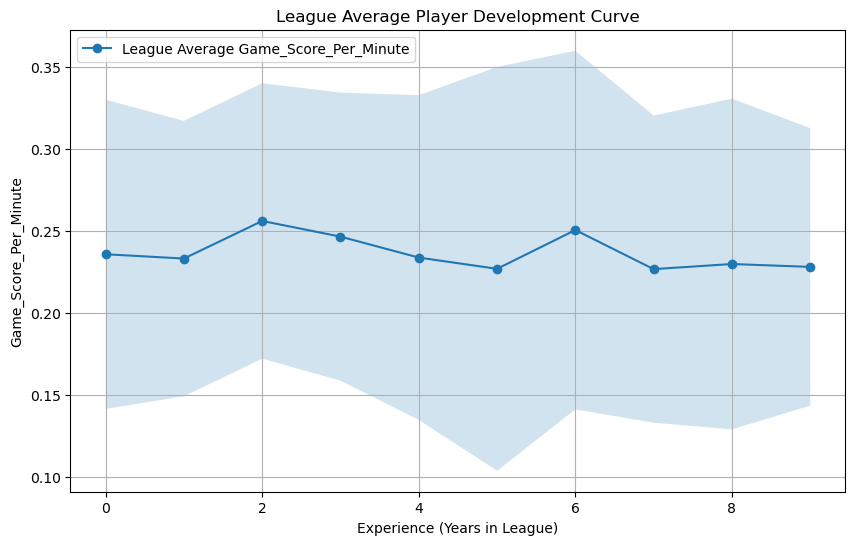

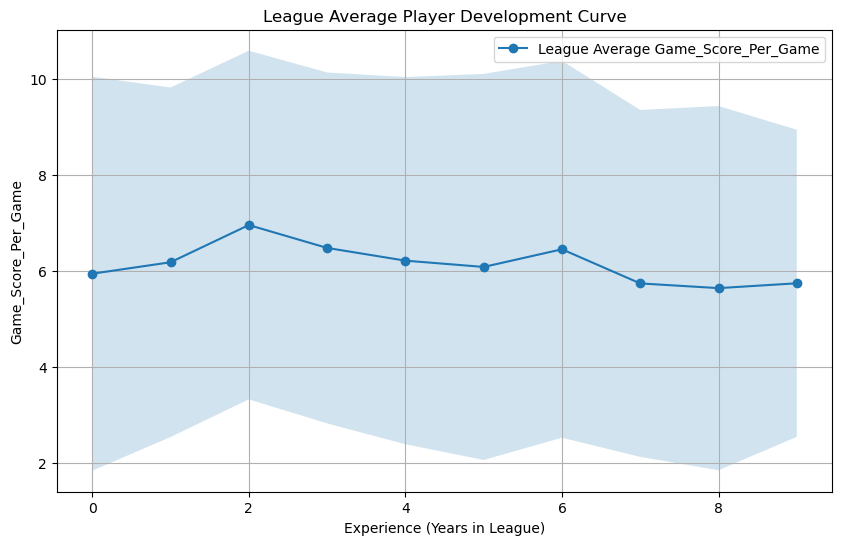

In [5]:
def compute_league_average_development(players_teams_df, 
                                                metric="Game_Score_Per_Game", 
                                                min_years=6, 
                                                min_total_minutes=500):
    """
    Computes the league average development curve considering only
    players with at least min_years of experience and min_total_minutes.
    """
    players = players_teams_df["playerID"].unique()
    experience_buckets = defaultdict(list)

    for pid in players:
        df_player = players_teams_df[players_teams_df["playerID"] == pid]
        
        # Skip players who haven't reached minimum years
        if df_player["year"].nunique() < min_years:
            continue
        
        # Skip players who haven't played enough minutes overall
        if df_player["minutes"].sum() < min_total_minutes:
            continue
        
        career = get_player_career_curve(players_teams_df, pid)
        if career.empty:
            continue
        
        for _, row in career.iterrows():
            exp = int(row["Experience"])
            val = row[metric]
            if not np.isnan(val):
                experience_buckets[exp].append(val)

    # Build the averaged curve
    avg_curve = []
    for exp in sorted(experience_buckets.keys()):
        vals = experience_buckets[exp]
        avg_curve.append({
            "Experience": exp,
            "Mean": np.mean(vals),
            "Std": np.std(vals),
            "Count": len(vals)
        })

    avg_df = pd.DataFrame(avg_curve)
    return avg_df


def plot_league_average_development(avg_df, metric_name="Game_Score_Per_Game"):
    """
    Plot the league-wide average curve with shaded variance.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(
        avg_df["Experience"],
        avg_df["Mean"],
        marker="o",
        label=f"League Average {metric_name}"
    )

    # Add standard deviation shading
    plt.fill_between(
        avg_df["Experience"],
        avg_df["Mean"] - avg_df["Std"],
        avg_df["Mean"] + avg_df["Std"],
        alpha=0.2
    )

    plt.title("League Average Player Development Curve")
    plt.xlabel("Experience (Years in League)")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()

avg_curve_min = compute_league_average_development(players_teams, metric="Game_Score_Per_Minute")
avg_curve_game = compute_league_average_development(players_teams, metric="Game_Score_Per_Game")
plot_league_average_development(avg_curve_min, metric_name="Game_Score_Per_Minute")
plot_league_average_development(avg_curve_game, metric_name="Game_Score_Per_Game")

## Feature Engineering

In [6]:
def get_player_season_stats(players_teams_df, player_id, year): 
    """
    Returns stats for a given player and season.
    """
    df = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ]

    if df.empty:
        return None

    score = get_player_game_score(players_teams_df, player_id, year)

    return {
        "playerID": player_id,
        "year": year,
        "tmID": df["tmID"].iloc[0],
        "GP": df["GP"].sum(),
        "minutes": df["minutes"].sum(),
        "PTS": df["points"].sum(),
        "REB": (df["oRebounds"] + df["dRebounds"]).sum(),
        "AST": df["assists"].sum(),
        "STL": df["steals"].sum(),
        "BLK": df["blocks"].sum(),
        "TOV": df["turnovers"].sum(),
        "Game_Score_Per_Game": score["Game_Score_Per_Game"],
        "Game_Score_Per_Minute": score["Game_Score_Per_Minute"],
        "Game_Score_Total": score["Game_Score_Total"]
    }


def get_player_experience(players_teams_df, player_id, year):
    seasons = sorted(players_teams_df[players_teams_df["playerID"] == player_id]["year"].unique())
    if not seasons:
        return 0
    first_year = seasons[0]
    return year - first_year


def get_previous_season_features(players_teams_df, player_id, year):
    return get_player_season_stats(players_teams_df, player_id, year - 1)


def compute_development(current_stats, previous_stats):
    if previous_stats is None:
        return None  # rookies have no development
    
    return {
        "Delta_Game_Score": current_stats["Game_Score_Per_Game"] - previous_stats["Game_Score_Per_Game"],
        "Delta_Minutes": current_stats["minutes"] - previous_stats["minutes"],
        "Delta_PTS": current_stats["PTS"] - previous_stats["PTS"],
        "Delta_REB": current_stats["REB"] - previous_stats["REB"],
        "Delta_AST": current_stats["AST"] - previous_stats["AST"],
    }


def expected_league_game_score(avg_curve, experience):
    row = avg_curve[avg_curve["Experience"] == experience]
    if row.empty:
        return None
    return float(row["Mean"].iloc[0])


def compute_expected_development(avg_curve, experience):
    exp_current = expected_league_game_score(avg_curve, experience)
    exp_prev = expected_league_game_score(avg_curve, experience - 1)

    if exp_prev is None or exp_current is None:
        return None

    return exp_current - exp_prev


def compute_trend(df, player, year, stat="PTS"):
    values = []
    for offset in [1, 2, 3]:
        row = get_player_season_stats(df, player, year - offset)
        if row is None:
            return None
        values.append(row.get(stat))
    if None in values:
        return None
    
    return (values[0] - values[1]) + (values[1] - values[2])


def compute_returning_minutes_share(players_teams_df, pid, year):
    team = players_teams_df[(players_teams_df["playerID"] == pid) &
                            (players_teams_df["year"] == year)]["tmID"].iloc[0]

    prev_year = year - 1

    # minutes played by team last season
    prev_team_players = players_teams_df[
        (players_teams_df["tmID"] == team) &
        (players_teams_df["year"] == prev_year)
    ]

    if len(prev_team_players) == 0:
        return 0.0

    total_prev_minutes = prev_team_players["minutes"].sum()

    # minutes returned by players still on roster current year
    current_team_players = players_teams_df[
        (players_teams_df["tmID"] == team) &
        (players_teams_df["year"] == year)
    ]

    returning_minutes = prev_team_players[
        prev_team_players["playerID"].isin(current_team_players["playerID"])
    ]["minutes"].sum()

    return returning_minutes / total_prev_minutes if total_prev_minutes > 0 else 0.0


def compute_minutes_freed(players_teams_df, tmID, year):
    curr_team = players_teams_df[(players_teams_df["tmID"] == tmID) & 
                                 (players_teams_df["year"] == year)]

    prev_team = players_teams_df[(players_teams_df["tmID"] == tmID) & 
                                 (players_teams_df["year"] == year - 1)]

    if prev_team.empty:
        return 0.0  # expansion or first year available

    # players who are NOT in current year
    left_players = prev_team[~prev_team["playerID"].isin(curr_team["playerID"])]

    return float(left_players["minutes"].sum())


# Build the full player–year dataset
def build_mip_training_table(players_teams_df, avg_curve):
    rows = []

    players = players_teams_df["playerID"].unique()
    years = sorted(players_teams_df["year"].unique())

    for pid in players:
        for yr in years:

            # --- CURRENT SEASON BASIC DATA ---
            current = get_player_season_stats(players_teams_df, pid, yr)
            if current is None:
                continue

            # --- EXPERIENCE (before season) ---
            exp = get_player_experience(players_teams_df, pid, yr)

            # --- PREVIOUS SEASON STATS ---
            prev = get_previous_season_features(players_teams_df, pid, yr)
            if prev is None:
                continue  # cannot do preseason model for players with no previous season

            # --- AGE ---
            # age = current.get("Age", None)

            # --- TEAM CHANGE ---
            if prev is None:
                team_change = 0
            else:
                team_change = int(current["tmID"] != prev["tmID"])

            # --- 3-YEAR TRENDS ---
            pts_trend_3yr = compute_trend(players_teams_df, pid, yr, stat="PTS")
            minutes_trend_3yr = compute_trend(players_teams_df, pid, yr, stat="Minutes")

            # --- EXPECTED IMPROVEMENT (based on curve & experience) ---
            expected_dev = compute_expected_development(avg_curve, exp)

            # --- TEAM CONTINUITY (returning minutes share) ---
            returning_minutes_share = compute_returning_minutes_share(players_teams_df, pid, yr)

            # Projected Role Increase (more minutes available = bigger role)
            projected_role_increase = float(expected_dev) - 0.7 * float(returning_minutes_share)

            # Coach Change
            if prev:
                coach_change = int(current.get("coachID") != prev.get("coachID"))
            else:
                coach_change = 0

            minutes_freed = compute_minutes_freed(players_teams_df, current["tmID"], yr)

            # --- TARGET VARIABLE ---
            won_mip = int(
                (
                    (awards["playerID"] == pid) &
                    (awards["year"] == yr) &
                    (awards["award"] == "Most Improved Player")
                ).any()
            )

            # --- BUILD ROW ---
            rows.append({
                "playerID": pid,
                "year": yr,
                # "Age": age,
                "Experience": exp,

                # previous-season data only
                "GS_Prev": prev["Game_Score_Per_Game"],
                "PTS_Prev": prev["PTS"],
                "MIN_Prev": prev["minutes"],

                # new preseason features
                "Team_Change": team_change,
                "PTS_Trend_3yr": pts_trend_3yr,
                #"Minutes_Trend_3yr": minutes_trend_3yr,
                "Returning_Minutes_Share": returning_minutes_share,
                "Expected_Improvement": expected_dev,
                "Projected_Role_Increase": projected_role_increase,
                #"Coach_Change": coach_change,
                "Minutes_Freed": minutes_freed,

                # target
                "Won_MIP": won_mip
            })

    df = pd.DataFrame(rows)

    # Remove any players with insufficient data
    df = df.dropna(subset=["GS_Prev", "PTS_Prev", "MIN_Prev"])

    df.to_csv("training_data_mip.csv", index=False)
    return df




mip_training_data = build_mip_training_table(players_teams, avg_curve_game)
print("MIP Training Data Sample:\n", mip_training_data.head())



MIP Training Data Sample:
      playerID  year  Experience   GS_Prev  PTS_Prev  MIN_Prev  Team_Change  \
0  abrossv01w     3           1  8.111538       343       846            0   
1  abrossv01w     4           2  5.481481       314       805            0   
2  abrossv01w     5           3  6.636667       318       792            0   
3  abrossv01w     6           4  4.236364       146       462            0   
4  abrossv01w     7           5  5.480645       304       777            0   

   PTS_Trend_3yr  Returning_Minutes_Share  Expected_Improvement  \
0            NaN                 0.800696              0.238238   
1            NaN                 0.841343              0.774562   
2          -25.0                 0.586315             -0.476275   
3         -168.0                 0.676431             -0.264749   
4          -14.0                 0.565332             -0.131160   

   Projected_Role_Increase  Minutes_Freed  Won_MIP  
0                -0.322249         1146.0       

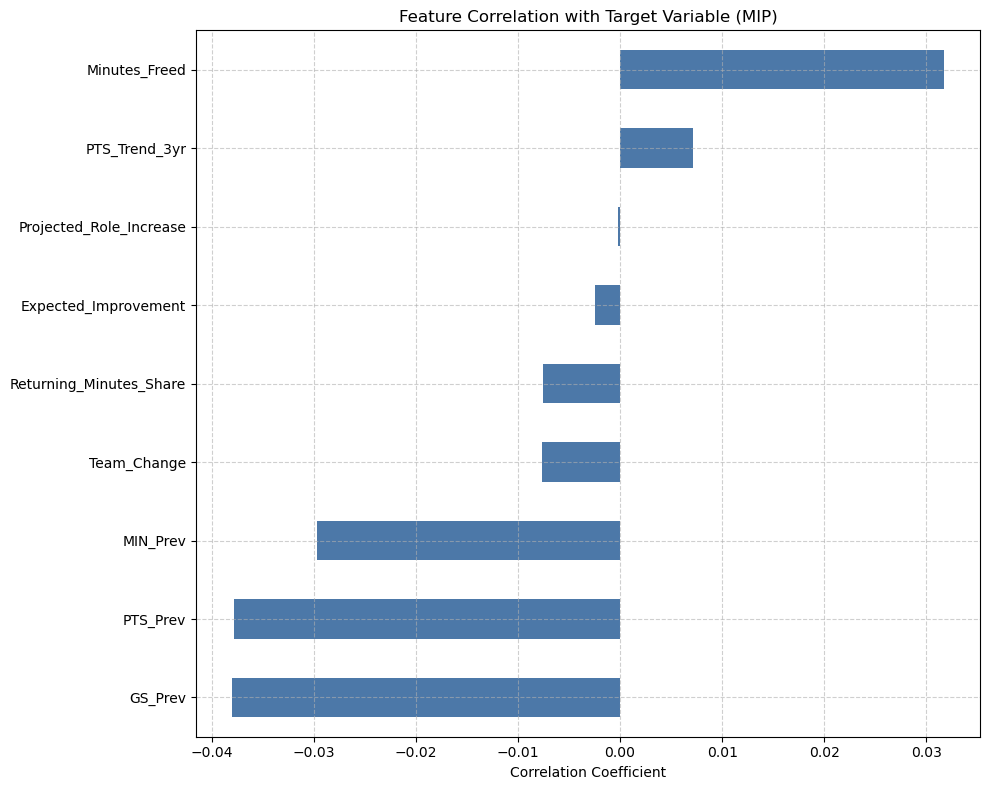

Top Positive Correlations:
Target                     1.000000
Minutes_Freed              0.031759
PTS_Trend_3yr              0.007139
Projected_Role_Increase   -0.000227
Expected_Improvement      -0.002465
Returning_Minutes_Share   -0.007507
Name: Target, dtype: float64

Top Negative Correlations:
Returning_Minutes_Share   -0.007507
Team_Change               -0.007633
MIN_Prev                  -0.029670
PTS_Prev                  -0.037789
GS_Prev                   -0.038037
Name: Target, dtype: float64


In [7]:
# ===============================================
# FEATURE CORRELATION ANALYSIS (features vs MIP target)
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load or use in-memory training data (historical preseason features)
try:
    corr_df = mip_training_data.copy()
except NameError:
    corr_df = pd.read_csv("training_data_mip.csv")

# Engineered features and target for MIP
feature_columns = [
    "GS_Prev",
    "PTS_Prev",
    "MIN_Prev",
    "Returning_Minutes_Share",
    "Projected_Role_Increase",
    "Minutes_Freed",
    # include optional engineered features where available
    "Team_Change",
    "PTS_Trend_3yr",
    #"Minutes_Trend_3yr",
    "Expected_Improvement",
    #"Coach_Change",
]

# Filter to available columns
feature_columns = [c for c in feature_columns if c in corr_df.columns]

# Rename target to 'Target' for clarity
candidates = corr_df[feature_columns + ["Won_MIP"]].copy().fillna(0)
if "Won_MIP" not in candidates.columns or len(feature_columns) == 0:
    print("Insufficient columns to compute correlation analysis.")
else:
    candidates = candidates.rename(columns={"Won_MIP": "Target"})

    # Compute correlation of features with Target
    correlation = candidates[feature_columns + ["Target"]].corr(numeric_only=True)["Target"].sort_values(ascending=False)

    # Plot correlation (horizontal bar), invert y for descending order
    plt.figure(figsize=(10, 8))
    correlation.drop("Target").plot(kind="barh", color="#4C78A8")
    plt.title("Feature Correlation with Target Variable (MIP)")
    plt.xlabel("Correlation Coefficient")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("Top Positive Correlations:")
    print(correlation.head(6))
    print("\nTop Negative Correlations:")
    print(correlation.tail(5))


## Predicative Model

## Overfitting

In [8]:
# ===============================================
# MULTI-MODEL ROLLING COMPARISON (MIP)
# Train on past seasons (< Y), predict season Y
# Models: LogisticRegression, ExtraTrees, GradientBoosting, RandomForest
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Load or reuse training data
try:
    _ = df.shape
except NameError:
    try:
        df = mip_training_data.copy()
    except NameError:
        df = pd.read_csv("training_data_mip.csv")

feature_cols = [
    "GS_Prev",
    "PTS_Prev",
    "MIN_Prev",
    "Returning_Minutes_Share",
    "Projected_Role_Increase",
    "Minutes_Freed",
]

season_winners = df.groupby("year")["Won_MIP"].sum()
valid_seasons = sorted(season_winners[season_winners > 0].index.tolist())

candidate_models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear", random_state=42))
    ]),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=600, max_depth=None, class_weight="balanced", random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=600, max_depth=6, min_samples_split=20, min_samples_leaf=10, max_features=0.5, class_weight={0:1,1:200}, n_jobs=-1, random_state=42),
}

# Rolling evaluation helper
def rolling_eval_mip(model, df, feature_cols, valid_seasons):
    rows = []
    for year in valid_seasons:
        train = df[df["year"] < year]
        test = df[df["year"] == year].copy()
        if train.empty or test.empty:
            continue
        X_train = train[feature_cols].fillna(0)
        y_train = train["Won_MIP"]
        X_test = test[feature_cols].fillna(0)
        y_test = test["Won_MIP"].values

        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        if probs is None:
            # Fallback for models without predict_proba
            preds = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict(X_test)
            # Min-max scale to [0,1]
            mn, mx = np.min(preds), np.max(preds)
            probs = (preds - mn) / (mx - mn + 1e-9)

        test["Pred_Prob"] = probs
        test["Rank"] = test["Pred_Prob"].rank(ascending=False, method="first")

        top1_hit = int((test[test["Rank"] <= 1]["Won_MIP"] == 1).any())
        top5_hit = int((test[test["Rank"] <= 5]["Won_MIP"] == 1).any())
        top10_hit = int((test[test["Rank"] <= 10]["Won_MIP"] == 1).any())
        winner_rows = test[test["Won_MIP"] == 1]
        actual_rank = int(winner_rows["Rank"].iloc[0]) if not winner_rows.empty else None

        # AUC per year (only if both classes present)
        auc = None
        if len(set(y_test)) > 1:
            try:
                auc = float(roc_auc_score(y_test, probs))
            except Exception:
                auc = None

        rows.append({
            "Year": year,
            "Top1_Hit": top1_hit,
            "Top5_Hit": top5_hit,
            "Top10_Hit": top10_hit,
            "Actual_Winner_Rank": actual_rank,
            "AUC": auc,
        })
    return pd.DataFrame(rows)

# Run comparison
comparison = {}
for name, mdl in candidate_models.items():
    res = rolling_eval_mip(mdl, df, feature_cols, valid_seasons)
    comparison[name] = res
    print(f"\n=== {name} MIP Rolling Evaluation (by year) ===")
    print(res.head())

# Build summary: mean metrics + std of rank + mean AUC
summary_rows = []
for name, res in comparison.items():
    ranks = res["Actual_Winner_Rank"].dropna()
    auc_mean = res["AUC"].dropna().mean() if "AUC" in res and not res["AUC"].dropna().empty else np.nan
    summary_rows.append({
        "Model": name,
        "Top1_Hit": res["Top1_Hit"].mean(),
        "Top5_Hit": res["Top5_Hit"].mean(),
        "Top10_Hit": res["Top10_Hit"].mean(),
        "Actual_Winner_Rank": ranks.mean() if not ranks.empty else np.nan,
        "Actual_Winner_Rank_STD": ranks.std(ddof=1) if not ranks.empty else np.nan,
        "AUC_Mean": auc_mean,
    })

summary_df = pd.DataFrame(summary_rows).sort_values([
    "Top1_Hit", "Top5_Hit", "Top10_Hit", "Actual_Winner_Rank"
], ascending=[False, False, False, True])

summary_df.to_csv("mip_rolling_model_summary.csv", index=False)
print("\n=== MIP Rolling Model Comparison Summary ===")
print(summary_df)



=== LogisticRegression MIP Rolling Evaluation (by year) ===
   Year  Top1_Hit  Top5_Hit  Top10_Hit  Actual_Winner_Rank       AUC
0     3         0         0          0                 150  0.056962
1     4         0         0          0                  94  0.295455
2     5         0         0          0                  55  0.721239
3     8         0         0          0                 102  0.223077
4     9         0         0          0                  23  0.822581

=== ExtraTrees MIP Rolling Evaluation (by year) ===
   Year  Top1_Hit  Top5_Hit  Top10_Hit  Actual_Winner_Rank       AUC
0     3         0         0          0                 120  0.256329
1     4         0         0          0                 121  0.291667
2     5         0         0          0                  20  0.738938
3     8         0         1          1                   4  0.976923
4     9         0         0          0                  25  0.806452

=== GradientBoosting MIP Rolling Evaluation (by year) ===

## Prediction

In [14]:
# ===============================
# Season 11 Preseason MIP Prediction (from test_data + historic data)
# ===============================
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

# Load season 11 roster from test_data (preseason composition only)
pt_test = pd.read_csv("../../data/test_data/players_teams.csv")
players_teams_11 = pt_test[pt_test["year"] == 11].copy()

# Load historic player-team stats from initial_data for previous season calculations
pt_hist = pd.read_csv("../../data/initial_data/players_teams.csv")
players_teams_10 = pt_hist[pt_hist["year"] == 10].copy()

# Reuse training table for training (seasons < 11)
try:
    base_df = mip_training_data.copy()
except NameError:
    base_df = pd.read_csv("training_data_mip.csv")

# Feature set used by models
feature_cols = [
    "GS_Prev",
    "PTS_Prev",
    "MIN_Prev",
    "Returning_Minutes_Share",
    "Projected_Role_Increase",
    "Minutes_Freed",
]

# Resolve schema differences in historic data and build previous-season aggregates
stat_candidates = {
    "GP": ["GP", "gp", "games"],
    "minutes": ["minutes", "MIN", "min"],
    "points": ["points", "PTS", "pts"],
    "oRebounds": ["oRebounds", "OREB", "oreb", "offReb", "off_reb"],
    "dRebounds": ["dRebounds", "DREB", "dreb", "defReb", "def_reb"],
    "assists": ["assists", "AST", "ast"],
    "steals": ["steals", "STL", "stl"],
    "blocks": ["blocks", "BLK", "blk"],
    "fgMade": ["fgMade", "FGM", "fgm"],
    "fgAttempted": ["fgAttempted", "FGA", "fga"],
    "ftMade": ["ftMade", "FTM", "ftm"],
    "ftAttempted": ["ftAttempted", "FTA", "fta"],
    "turnovers": ["turnovers", "TOV", "tov"],
}

def resolve_columns(df, candidates):
    mapping = {}
    for target, options in candidates.items():
        found = None
        for col in options:
            if col in df.columns:
                found = col
                break
        mapping[target] = found
    return mapping

colmap10 = resolve_columns(players_teams_10, stat_candidates)
missing_cols = [k for k, v in colmap10.items() if v is None]
if missing_cols:
    print("Warning: Missing columns in historic data for year 10:", missing_cols)

# Aggregate year-10 per player using resolved columns
agg_rows = []
for pid, grp in players_teams_10.groupby("playerID"):
    row = {"playerID": pid}
    for key, col in colmap10.items():
        row[key] = grp[col].sum() if col else 0
    agg_rows.append(row)
agg10 = pd.DataFrame(agg_rows)

# Compute Game Score per game for previous season (using resolved columns)
base_score = (
    agg10["points"]
    + 0.4 * agg10["fgMade"]
    - 0.7 * agg10["fgAttempted"]
    - 0.4 * (agg10["ftAttempted"] - agg10["ftMade"])
    + 0.7 * agg10["oRebounds"]
    + 0.3 * agg10["dRebounds"]
    + agg10["steals"]
    + 0.7 * agg10["assists"]
    + 0.7 * agg10["blocks"]
    - 0.4 * agg10["turnovers"]
)
agg10["GS_Prev"] = base_score / agg10["GP"].replace(0, np.nan)
agg10["PTS_Prev"] = agg10["points"]
agg10["MIN_Prev"] = agg10["minutes"]

# Team continuity metrics for season 11 (use historic year-10 for previous roster, test year-11 for current preseason roster)
def returning_minutes_share_for_player(pid):
    row11 = players_teams_11[players_teams_11["playerID"] == pid]
    if row11.empty:
        return np.nan, np.nan
    tm = row11["tmID"].iloc[0]
    prev_team = players_teams_10[players_teams_10["tmID"] == tm]
    if prev_team.empty:
        return 0.0, 0.0
    total_prev_minutes = prev_team[colmap10["minutes"]].sum() if colmap10["minutes"] else 0
    curr_team = players_teams_11[players_teams_11["tmID"] == tm]
    returning_minutes = prev_team[prev_team["playerID"].isin(curr_team["playerID"])][colmap10["minutes"]].sum() if colmap10["minutes"] else 0
    share = (returning_minutes / total_prev_minutes) if total_prev_minutes > 0 else 0.0
    left_players = prev_team[~prev_team["playerID"].isin(curr_team["playerID"])]
    minutes_freed = float(left_players[colmap10["minutes"]].sum()) if colmap10["minutes"] else 0.0
    return share, minutes_freed

# Build season-11 candidate list (from test_data) and merge previous-season stats (from historic data)
season11 = players_teams_11[["playerID", "tmID"]].drop_duplicates().merge(
    agg10[["playerID", "GS_Prev", "PTS_Prev", "MIN_Prev"]], on="playerID", how="left"
)

# Compute continuity metrics per player
shares = []
freed = []
for pid in season11["playerID"].tolist():
    s, f = returning_minutes_share_for_player(pid)
    shares.append(s)
    freed.append(f)
season11["Returning_Minutes_Share"] = shares
season11["Minutes_Freed"] = freed

# Projected role increase proxy (until a data-driven curve is fitted)
season11["Projected_Role_Increase"] = -0.7 * season11["Returning_Minutes_Share"].fillna(0)

# Filter to players with at least basic previous-season stats
season11 = season11.dropna(subset=["GS_Prev", "PTS_Prev", "MIN_Prev"]).copy()

if season11.empty:
    print("No season 11 candidates with computable preseason features from test + historic data.\n"
          "Ensure historic initial_data has year 10 stats for year 11 players.")
else:
    # Prepare data
    X11 = season11[feature_cols].fillna(0)

    # Train model on seasons < 11 using base_df
    train_df = base_df[base_df["year"] < 11].copy()
    X_train = train_df[feature_cols].fillna(0)
    y_train = train_df["Won_MIP"]

    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict season 11 probabilities and rank
    season11["Pred_Prob"] = model.predict_proba(X11)[:, 1]
    season11["Rank"] = season11["Pred_Prob"].rank(ascending=False, method="first")

    # Output top candidates including team
    top_n = 20
    season11_top = season11.sort_values("Pred_Prob", ascending=False).head(top_n)[[
        "playerID", "tmID", "Pred_Prob", "Rank"
    ]].reset_index(drop=True)

    print("=== Season 11 MIP Preseason Predictions (Top 20) ===")
    print(season11_top)

    # Save full predictions including team
    season11.sort_values("Pred_Prob", ascending=False)[[
        "playerID", "tmID", "Pred_Prob", "Rank"
    ]].to_csv("mip_season11_predictions.csv", index=False)
    print("Saved: mip_season11_predictions.csv")


=== Season 11 MIP Preseason Predictions (Top 20) ===
      playerID tmID  Pred_Prob  Rank
0   colemma01w  WAS   0.135501   1.0
1   mazzake01w  ATL   0.014376   2.0
2   miltode01w  LAS   0.007338   4.0
3   thompti01w  LAS   0.007338   5.0
4   hoffmeb01w  LAS   0.007338   3.0
5   quinnno01w  LAS   0.005403   6.0
6   penicti01w  LAS   0.004153   7.0
7   parkeca01w  LAS   0.003499   8.0
8    snowmi01w  CHI   0.002827   9.0
9   holliqu01w  NYL   0.002526  10.0
10  jacksti02w  TUL   0.001099  11.0
11  sanniol01w  PHO   0.000931  12.0
12  pricear01w  ATL   0.000794  13.0
13    elysh01w  IND   0.000747  14.0
14  braxtka01w  NYL   0.000617  15.0
15  braxtka01w  PHO   0.000617  16.0
16  parisco01w  ATL   0.000452  17.0
17  youngta01w  CHI   0.000373  19.0
18  murphsh01w  CHI   0.000373  18.0
19  tolivkr01w  LAS   0.000354  20.0
Saved: mip_season11_predictions.csv
